# Data preparation

In [1]:
import random

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import notebook

RANDOM_SEED = 42
VALID_LOSS_BENCHMARK = 1.993

## Reading dataset and creating mappings

In [2]:
words = open("../names.txt", "r").read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
chars = sorted(list(set(''.join(words))))

char2id = {s: i+1 for i, s in enumerate(chars)}
char2id['.'] = 0

id2char = {i: s for s, i in char2id.items()}

vocab_size = len(id2char)

In [4]:
print(char2id)
print()
print(id2char)
print()
print(f"Vocabulary size: {vocab_size}")

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}

Vocabulary size: 27


## Data split into sets

In [5]:
random.seed(RANDOM_SEED)
random.shuffle(words)

cutoff_train = int(0.8*len(words))
cutoff_dev = int(0.9*len(words))

print(f"Training set: {0}-{cutoff_train-1:,}")
print(f"Development set: {cutoff_train:,}-{cutoff_dev-1:,}")
print(f"Testing set: {cutoff_dev:,}-{len(words)-1:,}")

print(f"\nTotal words: {len(words):,}")

Training set: 0-25,625
Development set: 25,626-28,828
Testing set: 28,829-32,032

Total words: 32,033


In [6]:
words_train = words[:cutoff_train]
words_dev = words[cutoff_train:cutoff_dev]
words_test = words[cutoff_dev:]

print(f"Training set examples: {len(words_train):,} ({len(words_train)/len(words):.0%})")
print(f"Development set examples: {len(words_dev):,} ({len(words_dev)/len(words):.0%})")
print(f"Testing set examples: {len(words_test):,} ({len(words_test)/len(words):.0%})")

Training set examples: 25,626 (80%)
Development set examples: 3,203 (10%)
Testing set examples: 3,204 (10%)


In [7]:
def build_dataset(words, block_size):
    """Creates a dataset."""
    # Preallocating lists for dataset
    X, Y = [], []
    for word in words:
        # Creating a starting examples depending on block size
        context = [0] * block_size
        # Iterating through entire word with end of word token
        for char in word + '.':
            index = char2id[char]
            X.append(context)
            Y.append(index)
            # Adding the character index and shifting
            context = context[1:] + [index]
    
    # Casting as PyTorch tensors
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    return X, Y

Now we will use 8 characters previous characters of a name to predict the next one:

In [8]:
block_size = 8

# Building the datasets for three sets
X_train, Y_train = build_dataset(
    words=words_train, block_size=block_size,
)
X_dev, Y_dev = build_dataset(
    words=words_dev, block_size=block_size,
)
X_test, Y_test = build_dataset(
    words=words_test, block_size=block_size,
)

The encoded characters that compose the datasets we created above now look like this:

In [9]:
X_train, Y_train

(tensor([[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0, 25],
         [ 0,  0,  0,  ...,  0, 25, 21],
         ...,
         [ 0,  0,  0,  ..., 15, 12,  4],
         [ 0,  0,  0,  ..., 12,  4,  1],
         [ 0,  0,  8,  ...,  4,  1, 14]]),
 tensor([25, 21,  8,  ...,  1, 14,  0]))

In [10]:
X_dev, Y_dev

(tensor([[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  1],
         [ 0,  0,  0,  ...,  0,  1, 13],
         ...,
         [ 0,  0,  0,  ...,  8,  1, 25],
         [ 0,  0,  0,  ...,  1, 25, 12],
         [ 0,  0,  0,  ..., 25, 12,  1]]),
 tensor([ 1, 13,  1,  ..., 12,  1,  0]))

In [11]:
X_test, Y_test

(tensor([[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0, 13],
         [ 0,  0,  0,  ...,  0, 13, 21],
         ...,
         [ 0,  0,  0,  ..., 15, 22,  1],
         [ 0,  0,  0,  ..., 22,  1, 14],
         [ 0,  0, 25,  ...,  1, 14,  9]]),
 tensor([13, 21, 19,  ..., 14,  9,  0]))

Let's also vizualize the task at hand (predicting the 9th characters based on the information about the previous 8 ones). Let's consider the first 8 names from the training words:

In [12]:
i = 0
while i <= 7:
    print(words_train[i])
    i += 1

yuheng
diondre
xavien
jori
juanluis
erandi
phia
samatha


Next, we can picture these names in terms of characters:

In [13]:
for x, y in zip(X_train[:56], Y_train[:56]):
    print(''.join(id2char[ix.item()] for ix in x), '-->', id2char[y.item()])
    if y.item() == 0:
        print()

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .

........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .

........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e
...xavie --> n
..xavien --> .

........ --> j
.......j --> o
......jo --> r
.....jor --> i
....jori --> .

........ --> j
.......j --> u
......ju --> a
.....jua --> n
....juan --> l
...juanl --> u
..juanlu --> i
.juanlui --> s
juanluis --> .

........ --> e
.......e --> r
......er --> a
.....era --> n
....eran --> d
...erand --> i
..erandi --> .

........ --> p
.......p --> h
......ph --> i
.....phi --> a
....phia --> .

........ --> s
.......s --> a
......sa --> m
.....sam --> a
....sama --> t
...samat --> h
..samath --> a
.samatha --> .



# Creating WaveNet

The Neural Net we are going to consider here will be similar to the WaveNet. In other words, before proceeding to the next layer we will always be taking every two characters and will be fusing them together (as a bigram representation) consecutively, therefore slowly squashing all information rather than crushing it all at once.

## Building blocks

### Linear layer

In [14]:
class Linear:
    """Linear layer."""
  
    def __init__(self, fan_in, fan_out, bias=True):
        """Initializes an instance of Linear class."""
        # Initializing the parameters (Kaiming normal initialization)
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        # Optionally adding bias term
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        """Makes a forward pass."""
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        
        return self.out
    
    def parameters(self):
        """Collects trainable parameters."""
        
        return [self.weight] + ([] if self.bias is None else [self.bias])

### Batch normalization layer

In [15]:
class BatchNorm1d:
    """Batch normalization layer."""
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        """Initializes an instance of BatchNorm1d class."""
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # Setting trainable parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # Initializing the buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
  
    def __call__(self, x):
        """Makes a forward pass."""
        # Computing batch mean/variance (training model\)
        if self.training:
            # Choosing batch dimension (depending on input dimensions)
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            # Computing batch mean/variance
            x_mean = x.mean(dim, keepdim=True)
            x_var = x.var(dim, keepdim=True)
        # Using pre-computed batch mean/variance (evaluation mode)
        else:
            x_mean = self.running_mean
            x_var = self.running_var
        
        # Computing layer outputs
        x_hat = (x - x_mean) / torch.sqrt(x_var + self.eps)
        self.out = self.gamma * x_hat + self.beta
        
        # Updating the buffers ("momentum update")
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var
        
        return self.out
  
    def parameters(self):
        """Collects the trainable parameters."""
        
        return [self.gamma, self.beta]

### Hyperbolic tangent activation

In [16]:
class Tanh:
    """Hyperbolic tangent activation."""
    def __call__(self, x):
        """Makes a forward pass."""
        self.out = torch.tanh(x)
        
        return self.out
    def parameters(self):
        """Collects trainable parameters."""
        
        return []

### Embedding layer

In [17]:
class Embedding:
    """Embedding layer."""
    
    def __init__(self, num_embeddings, embedding_dim):
        """Initializes an instance of Embedding class."""
        self.weight = torch.randn((num_embeddings, embedding_dim))
      
    def __call__(self, idx):
        """Makes a forward pass."""
        self.out = self.weight[idx]
        
        return self.out
    
    def parameters(self):
        """Collects the trainable parameters."""
        
        return [self.weight]

### Flattening layer

In [18]:
class FlattenConsecutive:
    """Flattening layer."""
  
    def __init__(self, n):
        """Initializes an instance of FlattenConsecutive layer."""
        self.n = n
      
    def __call__(self, x):
        """Makes a forward pass."""
        # Retrieving the input dimensions
        dim_1, dim_2, dim_3 = x.shape
        x = x.view(dim_1, dim_2 // self.n, dim_3 * self.n)
        
        # Removing unitary dimension when reaching
        if x.shape[1] == 1:
            x = x.squeeze(1)
        
        self.out = x
        
        return self.out
    
    def parameters(self):
        """Collects the trainable parameters."""
        
        return []

### Sequential

In [19]:
class Sequential:
    """Stacks up all layers together."""
  
    def __init__(self, layers):
        """Initializes an instance of Sequential class."""
        self.layers = layers
    
    def __call__(self, x):
        """Makes a forward pass."""
        # Forwards all layers
        for layer in self.layers:
            x = layer(x)
        
        self.out = x
        
        return self.out
  
    def parameters(self):
        """Get parameters of all layers and stretches them out into one list."""
        
        return [p for layer in self.layers for p in layer.parameters()]

## Initialization

In [20]:
torch.manual_seed(RANDOM_SEED);

In [21]:
# Setting the dimensionality of the character embedding vectors
n_embd = 32 # CHANGE 1: increasing from 24 (video) to 32

# Setting the number of neurons in the hidden layer of the MLP
n_hidden = 128

# Stacking up the layers
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# Making last layer less confident
with torch.no_grad():
    model.layers[-1].weight *= 0.1

# Computing the total number of trainable parameters
parameters = model.parameters()
nn_params_num = sum(p.nelement() for p in parameters)
print(f"Number of trainable parameters: {nn_params_num:,}")

# Enabling autogradient computations
for p in parameters:
    p.requires_grad = True

Number of trainable parameters: 78,843


In [22]:
# Displaying the NN architecture
for layer in model.layers:
    print(f"{layer.__class__.__name__}")
    if isinstance(layer, Tanh) or isinstance(layer, Embedding):
        print('-' * 33)

Embedding
---------------------------------
FlattenConsecutive
Linear
BatchNorm1d
Tanh
---------------------------------
FlattenConsecutive
Linear
BatchNorm1d
Tanh
---------------------------------
FlattenConsecutive
Linear
BatchNorm1d
Tanh
---------------------------------
Linear


# Verifying the shapes during forward pass

In [23]:
max_steps = 100000 # CHANGE 2: decreasing from 200000 (video) to 100000
batch_size = 32
lossi = []

In [24]:
# Launching the training (one iteration only)
for i in notebook.tqdm(range(max_steps)):
  
    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    Xb, Yb = X_train[ix], Y_train[ix]
    
    # Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Learning rate decay
    lr = 0.1 if i < 75000 else 0.01
    # Parameter updates
    for p in parameters:
        p.data -= lr * p.grad
    
    # Track statistics
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    lossi.append(loss.log10().item())
    
    # Stopping the training after one iteration
    break

  0%|          | 0/100000 [00:00<?, ?it/s]

      0/ 100000: 3.2889


In [25]:
for layer in model.layers:
    print(f"{layer.__class__.__name__:20s} {tuple(layer.out.shape)}")
    if isinstance(layer, Embedding) or isinstance(layer, Tanh):
        print('-' * 33)

Embedding            (32, 8, 32)
---------------------------------
FlattenConsecutive   (32, 4, 64)
Linear               (32, 4, 128)
BatchNorm1d          (32, 4, 128)
Tanh                 (32, 4, 128)
---------------------------------
FlattenConsecutive   (32, 2, 256)
Linear               (32, 2, 128)
BatchNorm1d          (32, 2, 128)
Tanh                 (32, 2, 128)
---------------------------------
FlattenConsecutive   (32, 256)
Linear               (32, 128)
BatchNorm1d          (32, 128)
Tanh                 (32, 128)
---------------------------------
Linear               (32, 27)


# Training the MLP

In [26]:
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
nn_params_num = sum(p.nelement() for p in parameters)
print(f"Number of trainable parameters: {nn_params_num:,}")

for p in parameters:
    p.requires_grad = True

Number of trainable parameters: 78,843


In [27]:
# Displaying the NN architecture
for layer in model.layers:
    print(f"{layer.__class__.__name__}")
    if isinstance(layer, Tanh) or isinstance(layer, Embedding):
        print('-' * 33)

Embedding
---------------------------------
FlattenConsecutive
Linear
BatchNorm1d
Tanh
---------------------------------
FlattenConsecutive
Linear
BatchNorm1d
Tanh
---------------------------------
FlattenConsecutive
Linear
BatchNorm1d
Tanh
---------------------------------
Linear


In [28]:
lossi = []

for i in notebook.tqdm(range(max_steps)):
  
    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    Xb, Yb = X_train[ix], Y_train[ix]
    
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 if i < int(0.75 * max_steps) else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    
    if i % (max_steps // 10) == 0:
        print(f'{i:7d}/{max_steps:7d}: train_loss = {loss.item():.4f}')
    
    lossi.append(loss.log10().item())

  0%|          | 0/100000 [00:00<?, ?it/s]

      0/ 100000: train_loss = 3.2864
  10000/ 100000: train_loss = 2.1543
  20000/ 100000: train_loss = 1.7248
  30000/ 100000: train_loss = 1.7390
  40000/ 100000: train_loss = 2.1115
  50000/ 100000: train_loss = 2.0811
  60000/ 100000: train_loss = 1.7658
  70000/ 100000: train_loss = 2.1511
  80000/ 100000: train_loss = 2.4455
  90000/ 100000: train_loss = 1.7456


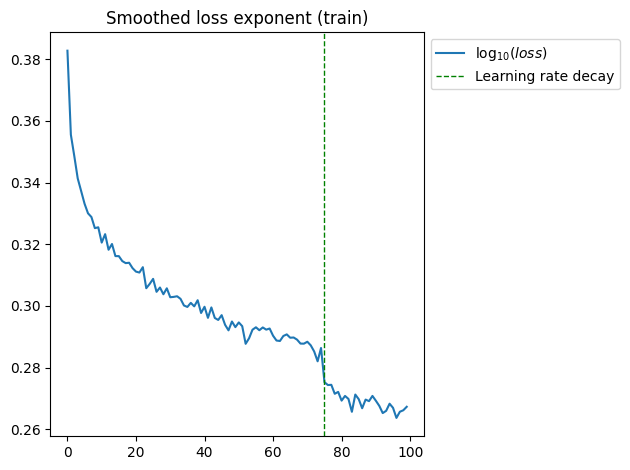

In [29]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1), label=r'$\log_{10}(loss)$')

m = int(0.75 * max_steps) / 1000
plt.axvline(x=m, color='g', label='Learning rate decay', linestyle='--', linewidth=1)
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.title("Smoothed loss exponent (train)")
plt.tight_layout()
plt.show()

# Evaluation

In [30]:
# Enabling evaluation mode
for layer in model.layers:
    layer.training = False

In [31]:
@torch.no_grad()
def compute_loss(split):
    """Computes the loss for a data split."""
    # Saving the data splits
    x, y = {
      'train': (X_train, Y_train),
      'valid': (X_dev, Y_dev),
      'test': (X_test, Y_test),
    }[split]
    
    # Forwarding the model and computing loss
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    
    return loss.item()

In [32]:
train_loss = compute_loss(split='train')
valid_loss = compute_loss(split='valid')

print(f"Training loss: {train_loss:.4f}")
print(f"Validation loss: {valid_loss:.4f}")

assert valid_loss < VALID_LOSS_BENCHMARK

Training loss: 1.8312
Validation loss: 1.9878


In [33]:
test_loss = compute_loss(split='test')
print(f"Test loss: {test_loss:.4f}")

Test loss: 1.9826


# Generating names

In [34]:
for _ in range(100):
    
    # Preallocating memory
    out = []
    context = [0] * block_size
    
    # Sequentially creating a name
    while True:
        
        # Forward pass
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        
        # Getting a sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        
        # Shifting the context window
        context = context[1:] + [ix]
        out.append(ix)
        # Stopping interating when encountering "."
        if ix == 0:
            break
    
    # Decoding and printing the generated word
    print(''.join(id2char[i] for i in out)[:-1].capitalize())

Oziel
Romey
Kay
Tofire
Kater
Regan
Kaleigh
Shayme
Castyn
Sawey
Elenia
Jhanvy
Adalena
Oluwatou
Aylia
Londyn
Kayse
Jabiyana
Callistani
Uzan
Taiman
Sumeem
Delaniya
Hovasiah
Kairaj
Naya
Tigmar
Eliany
Makha
Jabrie
Ryane
Mylinna
Azaen
Kayslyn
Jurst
Carsol
Sejin
Kadie
Hawil
Bay
Naylen
Yashir
Bihal
Mitri
Novi
Willory
Anser
Aiyla
Cresten
Lyndane
Jontay
Dewrin
Leyahi
Kritana
Aadha
Lynn
Locson
Kaalai
Dariel
Lidaniya
Afery
Krish
Livanna
Razan
Nakyn
Julina
Davyn
Evers
Lneere
Karston
Jadesin
Brisoluce
Chollinootdryc
Livey
Artave
Jaquav
Braelynn
Elikahee
Kieja
Renas
Kenvin
Moaga
Ea
Jamila
Kinsleighan
Syinna
Melino
Naniha
Audra
Shamik
Acevia
Keanon
Amerie
Nicolayus
Alayiah
Zethila
Reilynn
Dssaleria
Luseanna
Lawsyn
